In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# Swiler's file paths for each dataset
gdp_data = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/GDP.csv', parse_dates=['DATE'])
cpat_tax = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/CPATAX.csv', parse_dates=['DATE'])
durable_goods = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/manufacturers_new_orders_durable_goods_excluding_defense.csv', parse_dates=['DATE'])
housing_starts = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/housing start.csv', parse_dates=['DATE'])
industrial_production = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/industrial_production_total_index.csv', parse_dates=['DATE'])
personal_consumption = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/PCECTPI.csv', parse_dates=['DATE'])
t10y2y = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/T10Y2Y.csv', parse_dates=['DATE'])
sp500_vix = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/sp500_vix_quarterly.csv', parse_dates=['Date'])
gtrend_recession = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_recession.csv', parse_dates=['Month'])
gtrend_unemployment = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_unemployment.csv', parse_dates=['Month'])
nonderiv_insider_activity = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/nonderiv_insider_activity.csv', parse_dates=['transactionDate'])

In [3]:
#Henry's file paths for each dataset

In [4]:
# Merge datasets on their respective date columns
data = gdp_data.copy()  # Start with GDP data

# Merge other datasets using 'DATE' or appropriate columns
data = data.merge(cpat_tax, on='DATE', how='left')
data = data.merge(durable_goods, on='DATE', how='left')
data = data.merge(housing_starts, on='DATE', how='left')
data = data.merge(industrial_production, on='DATE', how='left')
data = data.merge(personal_consumption, on='DATE', how='left')
data = data.merge(t10y2y, on='DATE', how='left')
data = data.merge(sp500_vix.rename(columns={'Date': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_recession.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_unemployment.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(nonderiv_insider_activity.rename(columns={'transactionDate': 'DATE'}), on='DATE', how='left')

#print
print(data.head(50))

         DATE      GDP  CPATAX  ADXDNO        HOUST  IPB50001SQ  PCECTPI  \
0  1947-01-01  243.164   9.959     NaN          NaN     13.7361   11.557   
1  1947-04-01  245.968  13.603     NaN          NaN     13.7450   11.649   
2  1947-07-01  249.585  13.868     NaN          NaN     13.7719   11.866   
3  1947-10-01  259.745  14.455     NaN          NaN     14.1482   12.162   
4  1948-01-01  265.742  17.971     NaN          NaN     14.2916   12.297   
5  1948-04-01  272.567  19.109     NaN          NaN     14.4439   12.424   
6  1948-07-01  279.196  18.762     NaN          NaN     14.5783   12.614   
7  1948-10-01  280.366  20.713     NaN          NaN     14.4260   12.574   
8  1949-01-01  275.034  20.168     NaN          NaN     13.9601   12.475   
9  1949-04-01  271.351  19.144     NaN          NaN     13.5210   12.399   
10 1949-07-01  272.889  19.987     NaN          NaN     13.5479   12.327   
11 1949-10-01  270.627  16.892     NaN          NaN     13.4852   12.317   
12 1950-01-0

In [5]:
# Create a recession indicator based on a decline in GDP from one quarter to the next
data['GDP_diff'] = data['GDP'].diff()
data['Recession'] = np.where(data['GDP_diff'] < 0, 1, 0)

# Count the total number of recession periods
recession_count = data['Recession'].sum()

print(f"The U.S. has experienced {recession_count} recession periods based on two consecutive GDP declines.")

# Filter the dataset for recession periods
recession_periods = data[data['Recession'] == 1][['DATE', 'GDP']]

# Print the recession periods
print("Recession periods based on two consecutive GDP declines:")
print(recession_periods)


The U.S. has experienced 19 recession periods based on two consecutive GDP declines.
Recession periods based on two consecutive GDP declines:
          DATE        GDP
8   1949-01-01    275.034
9   1949-04-01    271.351
11  1949-10-01    270.627
26  1953-07-01    391.171
27  1953-10-01    385.970
28  1954-01-01    385.345
43  1957-10-01    474.864
44  1958-01-01    467.540
53  1960-04-01    541.080
55  1960-10-01    540.197
140 1982-01-01   3274.302
175 1990-10-01   6004.733
218 2001-07-01  10598.020
244 2008-01-01  14706.538
247 2008-10-01  14608.209
248 2009-01-01  14430.902
249 2009-04-01  14381.236
292 2020-01-01  21727.657
293 2020-04-01  19935.444


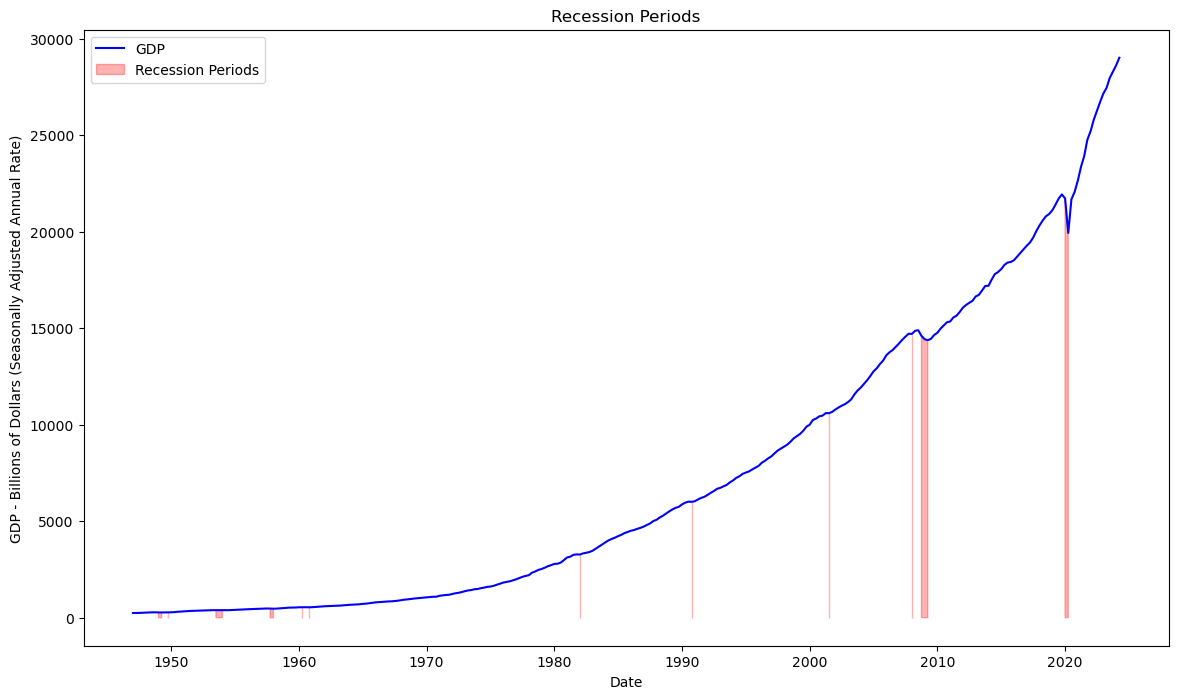

In [6]:
# Plot Recessions 
plt.figure(figsize=(14, 8))
plt.plot(data['DATE'], data['GDP'], label='GDP', color='blue')
plt.fill_between(data['DATE'], data['GDP'], where=data['Recession'] == 1, color='red', alpha=0.3, label='Recession Periods')
plt.title('Recession Periods')
plt.xlabel('Date')
plt.ylabel('GDP - Billions of Dollars (Seasonally Adjusted Annual Rate)')
plt.legend()
plt.show()

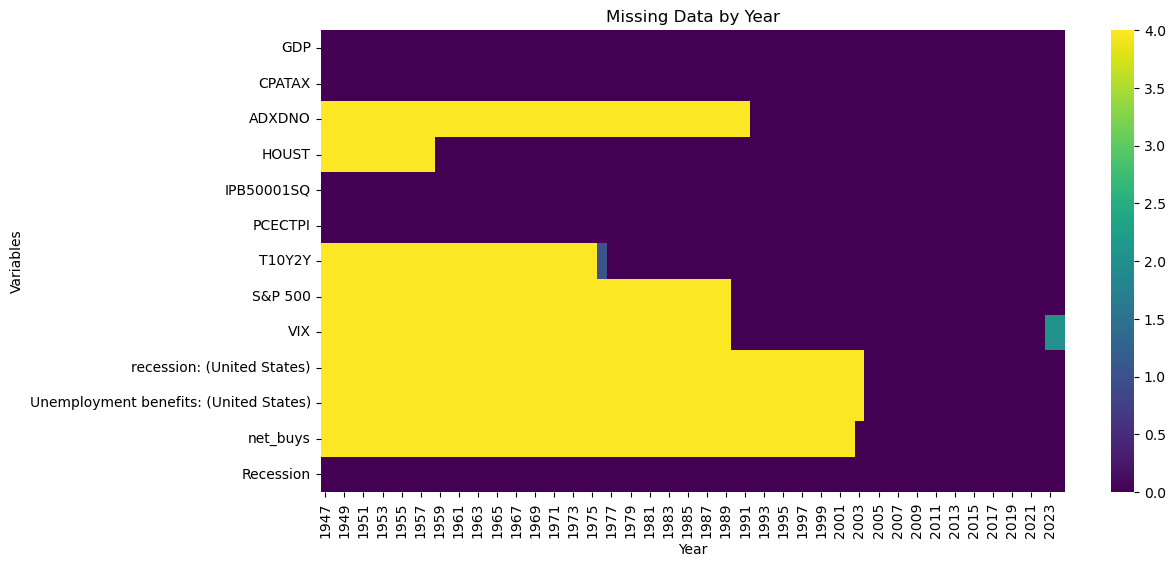

In [25]:
# Ensure the date column is in datetime format
data['Year'] = data['DATE'].dt.year  # Extract year from 'DATE' column

# Calculate missing values by year
missing_by_year = data.groupby('Year').apply(lambda x: x.isnull().sum())

# Drop the 'DATE' or other non-numeric columns from the missing data count
missing_by_year.drop(['DATE', 'Year', 'GDP_diff'], axis=1, inplace=True, errors='ignore')

plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_year.T, cmap='viridis', cbar=True)
plt.title('Missing Data by Year')
plt.xlabel('Year')
plt.ylabel('Variables')
plt.show()

